In [1]:
#Archivo con las funciones para calcular soluciones numéricas
include("UndrivenHelium.jl")
using Plots, LaTeXStrings
# plotly()
pyplot(grid = :false, legend = :false)

const Z = 2.0
const order = 30
const t0 = 0.0
const t_max = 0.5 
const abs_tol = 1.0E-20
const steps = 500000

500000

  5.794949 seconds (71.05 M allocations: 4.044 GiB, 22.46% gc time)



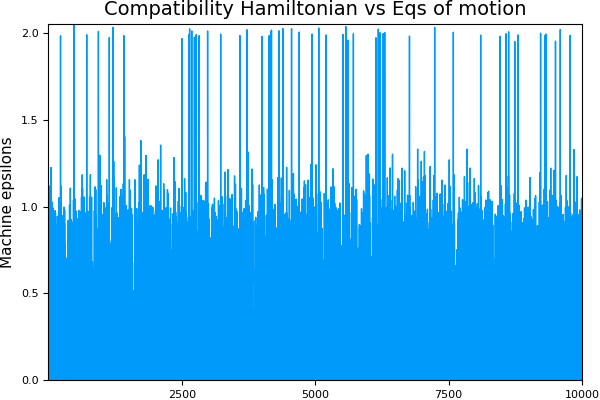

In [2]:
#Checamos compatibilidad 
@time dnorm = errHam2D(10_000);
plot(eachindex(dnorm), dnorm, title = "Compatibility Hamiltonian vs Eqs of motion")
yaxis!("Machine epsilons")

In [3]:
#Esta es la condición inicial que se aproximó en 1D
c2 = condini2D(2.577, 0.0, 0.0, 0.0, 0.0)
c1 = condini1D(2.577,0.0)

4-element Array{Float64,1}:
 1.6053
 0.0   
 0.0   
 4.0   

## Hacemos el comparativo de los integradores en 1D y 2D

In [4]:
t2, x2 = taylorinteg(undrivenHelium2D!, c2, t0, 1.0, order, abs_tol, maxsteps=5)
@time t2, x2 = taylorinteg(undrivenHelium2D!, c2, t0, 100.0, order, abs_tol, maxsteps = 5_000);

  3.042676 seconds (32.21 M allocations: 3.298 GiB, 20.99% gc time)


Maximum number of integration steps reached; exiting.


In [5]:
t1, x1 = taylorinteg(undrivenHelium1D!, c1, t0, 1.0, order, abs_tol, maxsteps=5)
@time t1, x1 = taylorinteg(undrivenHelium1D!, c1, t0, 100.0, order, abs_tol, maxsteps = 5_000);

In [6]:
t1[end], t2[end]

(16.922700133915505, 16.922700133915068)

In [7]:
x1[end,:]

4-element Array{Float64,1}:
 45.6067 
  1.16784
 35.193  
  2.0694 

In [8]:
x2[end,:]

8-element Array{Float64,1}:
 45.6067 
  0.0    
  1.16784
  0.0    
 35.193  
  0.0    
  2.0694 
  0.0    

In [9]:
regHam1D(x1[end,:])

-2.9103830456733704e-11

In [10]:
regHam2D(x2[end,:])

-3.637978807091713e-12